# Correlation Between AirBNB Price and Various Factors in NYC

## Preparation

In [42]:
# import packages
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plots
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import names 
from nltk import NaiveBayesClassifier as NBC
import requests
import re
import random

sia = SentimentIntensityAnalyzer()

In [79]:
# The following code is adopted from geeksforgeeks.com. We use it for gender identification training.
def gender_features(word):
    if len(word)==0:
        return {'lastletter': "x"}
    return {'lastletter': word[-1]}

maleNames = [(name, 'male') for name in names.words('male.txt')]
femaleNames = [(name, 'female') for name in names.words('female.txt')]
allNames = maleNames + femaleNames
random.shuffle(allNames)
featureData = [(gender_features(namelist), gender) for (namelist, gender) in allNames]
test_data = featureData[:700]
train_data = featureData[700:]
classifier = NBC.train(train_data)

In [8]:
# We defind a method to determine if a name belongs to a man or woman.
def get_gender(name):
    return classifier.classify(gender_features(str(name)))

In [9]:
# We run this line to see if we set empty names to male or female in the previous step:
get_gender("x")

'female'

In [10]:
# Define a function that only gets the first person's name in the host_name column.
def get_first_name(name):
    name = str(name)
    if " " in name:
        name = name.split(" ")[0]
    if "?" in name:
        name = name.split("?")[0]
    if "+" in name:
        name = name.split("+")[0]
    if "And" in name:
        name = name.split("And")[0]
    if "and" in name:
        name = name.split("and")[0]
    if "-" in name:
        name = name.split("-")[0]
    if "(" in name:
        name = name.split("(")[0]
    return name

In [99]:
# Define a function for sentiment analysis of the house description:
def get_sentiment(description):
    raw = str(sia.polarity_scores(str(description)))
    a = re.sub(r".*\:", "", raw, 1)
    b = float(re.sub(r"\}", "", a))
    return b

***********
## Data Cleaning

In [11]:
# import dataset
data_raw = pd.read_csv("AB_NYC_2019.csv")

In [12]:
# Clean our data by droping those houses with no reviews 
# as their prices may not fall in the range of people's expectation.
# Also we drop those houses with avaliability less than a week throughout the year
# as those people might just list their houses online for fun.
data_row = data_raw[data_raw.get("reviews_per_month")>0]
data_row = data_row[data_row.get("availability_365")>7]
data_row = data_row.assign(host_name = data_row.get("host_name").apply(get_first_name))
data_row

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48740,36413632,Spacious 2BR in Beautiful Brooklyn Heights,6608220,Matt,Brooklyn,Brooklyn Heights,40.69827,-73.99649,Entire home/apt,550,3,1,2019-07-07,1.00,1,230
48782,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,1.00,1,147
48790,36427429,No.2 with queen size bed,257683179,H Ai,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,1.00,6,339
48799,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,1.00,1,87


In [105]:
# We only keep the the columns that could be used as the independent factor for our prediction.
data_all_empty_male = pd.DataFrame().assign(host_name = data_row.get("host_name")).assign(host_gender = data_row.get("host_name").apply(get_gender)).assign(borough = data_row.get("neighbourhood_group")).assign(room_type = data_row.get("room_type")).assign(description_score = data_row.get("name").apply(get_sentiment)).assign(availabiliy = data_row.get("availability_365")).assign(price=data_row.get("price"))
data_all_empty_male

,host_name,host_gender,borough,room_type,description_score,availabiliy,price
0,John,male,Brooklyn,Private room,0.4019,365,149
1,Jennifer,male,Manhattan,Entire home/apt,0.0000,355,225
3,LisaRoxanne,female,Brooklyn,Entire home/apt,0.0000,194,89
5,Chris,male,Manhattan,Entire home/apt,0.0000,129,200
7,Shunichi,female,Manhattan,Private room,0.0000,220,79
...,...,...,...,...,...,...,...
48740,Matt,male,Brooklyn,Entire home/apt,0.5994,230,550
48782,Rusaa,female,Manhattan,Private room,0.5859,147,129
48790,H Ai,female,Queens,Private room,0.0000,339,45
48799,Ben,male,Staten Island,Private room,0.0000,87,235


In [27]:
# Since we assigned those with no names to male in the last step, we drop all of them.
for i in range(len(data_all_empty_male.get("host_name"))):
    if len(data_all_empty_male.get("host_name").iloc[i]) == 0:
        data_all_empty_male.get("host_gender").iloc[i] = "unknown"
data_with_names = data_all_empty_male

c:\users\wmy\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**********
## Actual Work

### Relation between price and gender
People have been suggesting if they use a female name on AirBNB, they can actually charge more on the same house than using a male name. Let's see if this is the case in NYC.

In [28]:
data = data_with_names.drop(columns = "host_name")
data = data[(data.get("host_gender")=="male")|(data.get("host_gender")=="female")]
data.groupby("host_gender").mean()

,availabiliy,price
host_gender,,
female,183.468301,148.170529
male,182.273887,155.086143


In [29]:
# We run a simulation test to see if avg male price is indeed higher than avg female price.
test_stats = np.array([])
for i in np.arange(5000):
    abc = data
    abc = abc.assign(test = np.random.permutation(abc.get("price")))
    diff = abc.groupby("host_gender").mean().get("test").loc["male"] - abc.groupby("host_gender").mean().get("test").loc["female"]
    test_stats = np.append(test_stats, diff)

In [30]:
# Create a 95% confidence interval:
lower_bound = np.percentile(test_stats,2.5)
upper_bound = np.percentile(test_stats,97.5)

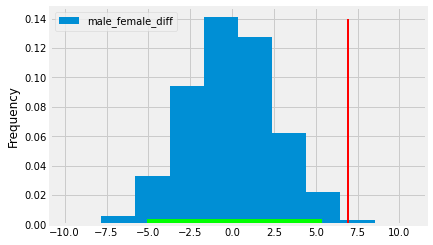

In [75]:
# Plot:
diff = data.groupby("host_gender").mean().get("price").loc["male"] - data.groupby("host_gender").mean().get("price").loc["female"]
bpd.DataFrame().assign(male_female_diff=test_stats).plot(kind='hist', density=True)
plots.plot([lower_bound, upper_bound], [0, 0],lw=10,color='lime')
plots.plot([diff, diff], [0, 0.14], lw=2, color='r');

In [78]:
p_value = np.count_nonzero(test_stats >= data.groupby("host_gender").mean().get("price").loc["male"] - data.groupby("host_gender").mean().get("price").loc["female"]) / len(test_stats)
p_value

0.0048

Since our p_value is smaller than 0.05, there is sufficient evidence that suggest the average AirBNB price set by male is higher than the average AirBNB price set by female in NYC.

In [ ]:
df_train = final
features = ['Black_population_percentage']
x = df_train.loc[:, features]
y = df_train.num_house_black_white_ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
print (linreg.coef_)
print (linreg.intercept_)

***********************
# Some Random Stuff
## Thoughts 
## Problems with the Project
1. Our methods of determining if a name belongs to a man or woman only includes checking the last letter of the name, so it is not 100% accurate. (I didn't find a better method online.) Also, some houses in our data are listed on AirBNB by agencies, but we treated them as a person as well.
_____________
2. The dataset does not have the feature "house size", which may play a very important role in determining the price.
**********
3. The "neighbourhood" column in the original .csv file may have strong correlation with the house price, but since it is too difficult to implement one-hot encoding for all of them, I simply ignored that column.